In [2]:
import networkx as nx
import pandas as pd
from pathlib import Path
from ast import literal_eval
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm



In [2]:
# read yaml file from data/spurious.yaml with yaml reader
# and convert to dictionary
import yaml
def read_yaml():
    with open(Path.cwd().parent / 'data' / 'spurious.yaml') as file:
        documents = yaml.full_load(file)
    return documents

# read yaml file from data/spurious.yaml with yaml reader
# and convert to dictionary

spur_df = read_yaml()


In [5]:
spurious = pd.DataFrame(spur_df['variables'])

In [93]:
spurious[::2]

,name,description
0,spending,"US spending on science, space, and technology"
2,pool,number of people who drowned by falling into a...
4,cheese,per capita cheese consumption
6,divorce,divorce rate in Maine
8,age,age of Miss America
10,revenue,total revenue generated by arcades
12,launches,worldwide non-commercial space launches
14,mozzarella,per capita consumption of mozzarella cheese
16,boat,people who drowned after falling out of a fish...
18,Norway,US crude oil imports from Norway


In [100]:
spurious.loc[::2,'Prediction'] = df['pred'].values

In [104]:
print(spurious.to_latex())

\begin{tabular}{llll}
\toprule
 & name & description & Prediction \\
\midrule
0 & spending & US spending on science, space, and technology & YES \\
1 & suicides & Suicides by hanging, strangulation and suffocation & NaN \\
2 & pool & number of people who drowned by falling into a pool per year & YES \\
3 & cage & number of films Nicolas Cage appeared in per year & NaN \\
4 & cheese & per capita cheese consumption & YES \\
5 & bed & number of people who died by becoming tangled in their bedsheet & NaN \\
6 & divorce & divorce rate in Maine & YES \\
7 & margarine & per capita consumption of margarine & NaN \\
8 & age & age of Miss America & YES \\
9 & murder & number of people murdered by steam, hot vapours and hot objects & NaN \\
10 & revenue & total revenue generated by arcades & NO \\
11 & CS & computer science doctorates awarded in the US & NaN \\
12 & launches & worldwide non-commercial space launches & YES \\
13 & Soc & sociology doctorates awarded (US) & NaN \\
14 & mozzarella & 

In [7]:
#options
burglary = 'burglary/2023-11-07 12:35:00.720656'  #2023-11-07 08:52:05.525438'
cancer = 'cancer_bnl/2023-11-07 13:01:43.837578'
asia = 'asia_bnl/2023-11-07 09:33:56.618510'
sachs1 = 'sachs/2023-11-07 12:08:09.402558'
sachs2 = 'sachs/2023-11-07 12:27:41.005704'
spurious1 = 'spourious/2023-11-09 13:39:44.568471'
spurious2 = 'spurious/2023-11-10 11:25:05.891713'


choice = burglary

In [8]:
path = Path.cwd().parent.joinpath('2023_GPT_PC','evaluations',spurious1,'predictions.csv')
# for adding sachs2
path2 = Path.cwd().parent.joinpath('2023_GPT_PC','evaluations',spurious2,'predictions.csv')


In [28]:
def test_prop(n_no, n_yes, n, null = "YES", alpha = 0.05):
    p_no = n_no / n # prop of no
    p_yes = n_yes / n # prop of yes
    p = (n_no + n_yes) / (2*n) # pooled prop 
    se = np.sqrt( p * (1 - p) * 2 / n) # standard error 
    if null == "YES":
        if p_yes > p_no:
            answ = "YES"
        else:
            answ = "NO"
        pval = norm.sf((p_no - p_yes) / se) # p_no - p_yes >> 0 is extreme for null == "YES" 
        if pval <= alpha:
            answ = "NO"
    if null == "NO":
        if p_yes > p_no:
            answ = "YES"
        else:
            answ = "NO"
        pval = norm.sf((p_yes - p_no) / se) # p_yes - p_no >> 0 is extreme for null == "NO" 
        if pval <= alpha:
            answ = "YES"
    return answ, pval


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None,
                          ax=None,
                          reduce_matrix=False,
                          own_labels=None
                          ):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.

    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    cf_size = len(cf)
    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False
    
    if reduce_matrix and cf.shape[0]==3:
        reduced = True
        cf = np.delete(cf, 1, axis=0)
        cf = np.delete(cf, 1, axis=1)
        
        box_labels = np.delete(box_labels, 1, axis=0)
        box_labels = np.delete(box_labels, 1, axis=1)

    if ax is None:
        # MAKE THE HEATMAP VISUALIZATION
        plt.figure(figsize=figsize)
        sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

        if own_labels is None:            
            if xyplotlabels:
                plt.ylabel('True label')
                plt.xlabel('Predicted label' + stats_text)
            else:
                plt.xlabel(stats_text)
        else:
            if xyplotlabels:
                plt.ylabel(own_labels[0])
                plt.xlabel(own_labels[1] + stats_text)
            else:
                plt.xlabel(stats_text)
        
        if title:
            plt.title(title)
    else:
        sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories, ax=ax)
        if own_labels is None:            
            if xyplotlabels:
                ax.set_ylabel('True label')
                ax.set_xlabel('Predicted label' + stats_text)
            else:
                ax.set_xlabel(stats_text)
        else:
            if xyplotlabels:
                ax.set_ylabel(own_labels[0])
                ax.set_xlabel(own_labels[1] + stats_text)
            else:
                ax.set_xlabel(stats_text)
        
        if title:
            ax.set_title(title)
            
    if cf_size == 2:
        return accuracy, precision, recall, f1_score
    elif cf_size == 1:
        return accuracy, None, None, None
    else:
        return []
        

In [11]:
# define a new table based on df
def condense_lines(x,y, criterion='counts'):
    new = x.copy()
    
    new['n_no'] = x['n_no'] + y['n_no']
    new['n_yes'] = x['n_yes'] + y['n_yes']
    new['n'] = x['n'] + y['n']
    
    
    new['no_conf'] = (x['n_no'] + y['n_no'])/(x['n'] + y['n'])
    new['yes_conf'] = (x['n_yes'] + y['n_yes'])/(x['n'] + y['n'])
        
    new['sum_rep_no_conf'] = x['sum_rep_no_conf'] + y['sum_rep_no_conf']
    new['sum_rep_yes_conf'] = x['sum_rep_yes_conf'] + y['sum_rep_yes_conf']

    for stat in ['avg', 'std', 'med', 'q25', 'q75']:
        for prop in [f'{stat}_rep_conf', f'{stat}_rep_no_conf', f'{stat}_rep_yes_conf']:
            new[prop] = None

    new['wpred'] = 'NO' if new['sum_rep_no_conf'] > new['sum_rep_yes_conf'] else 'YES'
    new['pred'] = 'NO' if new['n_no'] > new['n_yes'] else 'YES'
    
    return new

In [12]:
# Reading the data
df = pd.read_csv(path, index_col=0)
df['z'] = df['z'].fillna('[]')
df['z_n'] = np.array([len(literal_eval(z)) for z in df['z']])

for i in range(len(df)):
    df.loc[i,'ppred'], df.loc[i,'p'] = test_prop(df.loc[i,'n_no'], df.loc[i,'n_yes'], df.loc[i,'n'])


/tmp/ipykernel_14957/1863191995.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'YES' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[i,'ppred'], df.loc[i,'p'] = test_prop(df.loc[i,'n_no'], df.loc[i,'n_yes'], df.loc[i,'n'])


In [13]:
# read csv file from folder 2023_GPT_PC/evaluations/burglary/predictions into
# a pandas dataframe
# Add data_frames together
#for choices in [cancer, asia, sachs2]:
for choices in [spurious2]:
    path2 = Path.cwd().parent.joinpath('2023_GPT_PC','evaluations',choices,'predictions.csv')

    df2 = pd.read_csv(path2, index_col=0)
    df2['z'] = df2['z'].fillna('[]')
    df2['z_n'] = np.array([len(literal_eval(z)) for z in df2['z']])
    for i in range(len(df2)):
        df2.loc[i,'ppred'], df2.loc[i,'p'] = test_prop(df2.loc[i,'n_no'], df2.loc[i,'n_yes'], df2.loc[i,'n'])

    df = pd.concat([df, df2])
    
df = df.reset_index(drop=True)

/tmp/ipykernel_14957/1633966390.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'YES' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df2.loc[i,'ppred'], df2.loc[i,'p'] = test_prop(df2.loc[i,'n_no'], df2.loc[i,'n_yes'], df2.loc[i,'n'])


In [14]:
df = df.sort_values(by=['x'])

In [15]:
# run this to concatenate consecutive rows having XY and YX reponse
condense_df = pd.DataFrame(columns=df.columns)

for i in range(0, len(df), 2):
    new_row = condense_lines(df.iloc[i], df.iloc[i+1])
    condense_df.loc[len(condense_df)] = new_row

for i in range(len(condense_df)):
    condense_df.loc[i,'ppred'], condense_df.loc[i,'p'] = test_prop(condense_df.loc[i,'n_no'], condense_df.loc[i,'n_yes'], condense_df.loc[i,'n'])

# Run this in case of Sachs1 (data where there are not responses of XY and YX)
# condense_df = df

In [16]:
condense_df

,x,y,z,answ,type,pred,wpred,n_no,n_yes,n,...,q75_rep_no_conf,q75_rep_yes_conf,sha,tmstmp,model,temperature,data,z_n,ppred,p
0,Norway,railway,[],NO,listed,YES,YES,1,17,20,...,None,None,58b05370fdbc0670a82191fb357be774a2c0c22a,2023-11-09 13:39:44.568471,gpt-3.5-turbo,NaN,spourious,0,YES,1.0
1,age,murder,[],NO,listed,YES,YES,1,14,20,...,None,None,b31483393c4725bf5344802fad7925e2ce32c72a,2023-11-10 11:25:05.891713,gpt-3.5-turbo,NaN,spurious,0,YES,0.999989
2,boat,Kentucky,[],NO,listed,YES,YES,0,20,20,...,None,None,58b05370fdbc0670a82191fb357be774a2c0c22a,2023-11-09 13:39:44.568471,gpt-3.5-turbo,NaN,spourious,0,YES,1.0
3,cars,crashing,[],NO,listed,YES,YES,9,9,20,...,None,None,b31483393c4725bf5344802fad7925e2ce32c72a,2023-11-10 11:25:05.891713,gpt-3.5-turbo,NaN,spurious,0,YES,0.5
4,cheese,bed,[],NO,listed,YES,YES,0,18,20,...,None,None,b31483393c4725bf5344802fad7925e2ce32c72a,2023-11-10 11:25:05.891713,gpt-3.5-turbo,NaN,spurious,0,YES,1.0
5,chicken,oil,[],NO,listed,YES,YES,6,12,20,...,None,None,58b05370fdbc0670a82191fb357be774a2c0c22a,2023-11-09 13:39:44.568471,gpt-3.5-turbo,NaN,spourious,0,YES,0.971735
6,divorce,margarine,[],NO,listed,YES,YES,2,14,20,...,None,None,58b05370fdbc0670a82191fb357be774a2c0c22a,2023-11-09 13:39:44.568471,gpt-3.5-turbo,NaN,spourious,0,YES,0.999946
7,launches,Soc,[],NO,listed,YES,YES,4,16,20,...,None,None,58b05370fdbc0670a82191fb357be774a2c0c22a,2023-11-09 13:39:44.568471,gpt-3.5-turbo,NaN,spourious,0,YES,0.999926
8,maths,uranium,[],NO,listed,YES,YES,1,17,20,...,None,None,58b05370fdbc0670a82191fb357be774a2c0c22a,2023-11-09 13:39:44.568471,gpt-3.5-turbo,NaN,spourious,0,YES,1.0
9,mozzarella,engineering,[],NO,listed,YES,YES,0,18,20,...,None,None,b31483393c4725bf5344802fad7925e2ce32c72a,2023-11-10 11:25:05.891713,gpt-3.5-turbo,NaN,spurious,0,YES,1.0


In [10]:
cf_matrix

array([[132,  40],
       [ 27, 212]])

In [17]:
row_even = df['pred'][::2]
row_odd = df['pred'][range(1, len(df), 2)]
#Count the Yes and No predictions in row_even and in row_odd
sum(row_even[row_even=='YES'])

TypeError: unsupported operand type(s) for +: 'int' and 'str'

In [18]:
len(row_odd[row_odd=='YES']), len(row_odd[row_odd=='NO'])


(14, 1)

In [19]:
len(row_even[row_even=='YES']), len(row_even[row_even=='NO'])


(15, 0)

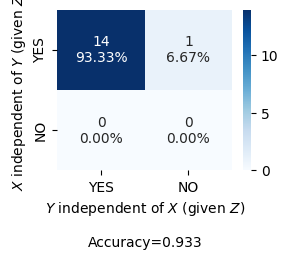

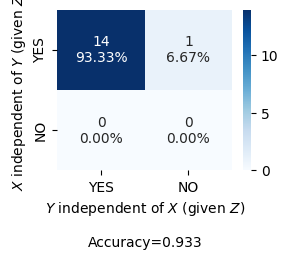

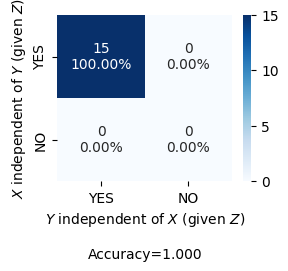

In [20]:
# Make two confusion matrices, one based on pred and one based on wpred
# skip for Sachs1
method_label = ['Majority vote', 'Weighted majority vote', 'p value']

for i, pred in enumerate(['pred', 'wpred', 'ppred']):
    fig, axes = plt.subplots(1,1, figsize = (3,3))
    row_even = df[pred][::2]
    row_odd = df[pred][range(1, len(df), 2)]
    cf_matrix = confusion_matrix(row_even, row_odd, labels=['YES', 'Uncertain','NO'], )
    #make_confusion_matrix(cf_matrix, ax=axes, title=f'Prediction based on {pred}', reduce_matrix=True, own_labels=[r'$X$ independent of $Y$', r'$Y$ independent of $X$'])
    make_confusion_matrix(cf_matrix, ax=axes, reduce_matrix=True, own_labels=[r'$X$ independent of $Y$ (given $Z$)', r'$Y$ independent of $X$ (given $Z$)'], group_names=['YES', 'NO'], categories=['YES', 'NO'] )
    #fig.suptitle(f'Consistency test: Confusion matrices for different conditioning sets on {choice}', fontsize=16)
    #fig.suptitle(f'Consistency test: Confusion matrices for different conditioning sets on burglary, cancer, asia, sachs', fontsize=10)

    # make space between subplots
    plt.subplots_adjust(hspace=1.0)
    # tight layout but with space for the title

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])


    #plt.savefig(f'../results/consistency_{choice[:5]}.pdf')
    plt.savefig(f'../results/consistency_all_{pred}_final.pdf')

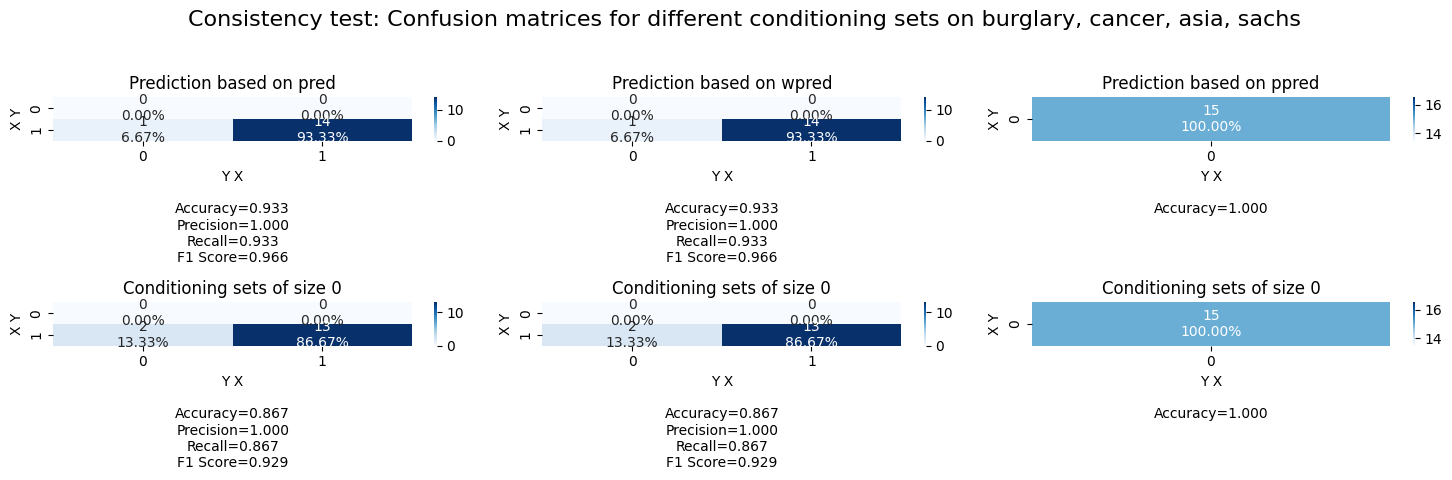

In [21]:
# Make two confusion matrices, one based on pred and one based on wpred
# skip for Sachs1
fig, axes = plt.subplots(len(condense_df['z_n'].unique())+1,3, figsize = (15,len(condense_df['z_n'].unique())*5))

for i, pred in enumerate(['pred', 'wpred', 'ppred']):
    row_even = df[pred][::2]
    row_odd = df[pred][range(1, len(df), 2)]
    cf_matrix = confusion_matrix(row_even, row_odd)
    make_confusion_matrix(cf_matrix, ax=axes[0,i], title=f'Prediction based on {pred}', reduce_matrix=True, own_labels=['X Y', 'Y X'])
    
    for j, z in enumerate(np.sort(df['z_n'].unique())):
        sub_df = df[df['z_n'] == z]
        # reset indices of sub_df
        sub_df = sub_df.reset_index(drop=True)

        row_even = sub_df[pred][::2]
        row_odd = sub_df[pred][range(1, len(sub_df), 2)]
        cf_matrix = confusion_matrix(row_even, row_odd)
        make_confusion_matrix(cf_matrix, ax=axes[j+1,i], title=f'Conditioning sets of size {z}', reduce_matrix=True, own_labels=['X Y', 'Y X'])

# add super title 
#fig.suptitle(f'Consistency test: Confusion matrices for different conditioning sets on {choice}', fontsize=16)
fig.suptitle(f'Consistency test: Confusion matrices for different conditioning sets on burglary, cancer, asia, sachs', fontsize=16)

# make space between subplots
plt.subplots_adjust(hspace=1.0)
# tight layout but with space for the title

plt.tight_layout(rect=[0, 0.03, 1, 0.95])


#plt.savefig(f'../results/consistency_{choice[:5]}.pdf')
plt.savefig(f'../results/consistency_all.pdf')

In [22]:
df

,x,y,z,answ,type,pred,wpred,n_no,n_yes,n,...,q75_rep_no_conf,q75_rep_yes_conf,sha,tmstmp,model,temperature,data,z_n,ppred,p
9,Norway,railway,[],NO,listed,YES,YES,1,8,10,...,0.5000,0.7125,58b05370fdbc0670a82191fb357be774a2c0c22a,2023-11-09 13:39:44.568471,gpt-3.5-turbo,NaN,spourious,0,YES,0.999173
24,Norway,railway,[],NO,listed,YES,YES,0,9,10,...,NaN,0.7000,b31483393c4725bf5344802fad7925e2ce32c72a,2023-11-10 11:25:05.891713,gpt-3.5-turbo,NaN,spurious,0,YES,0.999974
19,age,murder,[],NO,listed,YES,YES,1,6,10,...,0.7500,0.8500,b31483393c4725bf5344802fad7925e2ce32c72a,2023-11-10 11:25:05.891713,gpt-3.5-turbo,NaN,spurious,0,YES,0.990462
4,age,murder,[],NO,listed,YES,YES,0,8,10,...,NaN,0.7875,58b05370fdbc0670a82191fb357be774a2c0c22a,2023-11-09 13:39:44.568471,gpt-3.5-turbo,NaN,spourious,0,YES,0.999870
8,boat,Kentucky,[],NO,listed,YES,YES,0,10,10,...,NaN,0.7375,58b05370fdbc0670a82191fb357be774a2c0c22a,2023-11-09 13:39:44.568471,gpt-3.5-turbo,NaN,spourious,0,YES,0.999996
23,boat,Kentucky,[],NO,listed,YES,YES,0,10,10,...,NaN,0.7000,b31483393c4725bf5344802fad7925e2ce32c72a,2023-11-10 11:25:05.891713,gpt-3.5-turbo,NaN,spurious,0,YES,0.999996
27,cars,crashing,[],NO,listed,YES,YES,4,6,10,...,0.6000,0.7000,b31483393c4725bf5344802fad7925e2ce32c72a,2023-11-10 11:25:05.891713,gpt-3.5-turbo,NaN,spurious,0,YES,0.814453
12,cars,crashing,[],NO,listed,NO,NO,5,3,10,...,0.6000,0.7000,58b05370fdbc0670a82191fb357be774a2c0c22a,2023-11-09 13:39:44.568471,gpt-3.5-turbo,NaN,spourious,0,YES,0.180655
17,cheese,bed,[],NO,listed,YES,YES,0,9,10,...,NaN,0.7000,b31483393c4725bf5344802fad7925e2ce32c72a,2023-11-10 11:25:05.891713,gpt-3.5-turbo,NaN,spurious,0,YES,0.999974
2,cheese,bed,[],NO,listed,YES,YES,0,9,10,...,NaN,0.7000,58b05370fdbc0670a82191fb357be774a2c0c22a,2023-11-09 13:39:44.568471,gpt-3.5-turbo,NaN,spourious,0,YES,0.999974


/tmp/ipykernel_14957/3647851296.py:87: RuntimeWarning: invalid value encountered in scalar divide
  recall    = cf[1,1] / sum(cf[1,:])
/tmp/ipykernel_14957/3647851296.py:87: RuntimeWarning: invalid value encountered in scalar divide
  recall    = cf[1,1] / sum(cf[1,:])
/tmp/ipykernel_14957/3647851296.py:87: RuntimeWarning: invalid value encountered in scalar divide
  recall    = cf[1,1] / sum(cf[1,:])
/tmp/ipykernel_14957/3647851296.py:87: RuntimeWarning: invalid value encountered in scalar divide
  recall    = cf[1,1] / sum(cf[1,:])
/tmp/ipykernel_14957/3647851296.py:87: RuntimeWarning: invalid value encountered in scalar divide
  recall    = cf[1,1] / sum(cf[1,:])
/tmp/ipykernel_14957/3647851296.py:87: RuntimeWarning: invalid value encountered in scalar divide
  recall    = cf[1,1] / sum(cf[1,:])


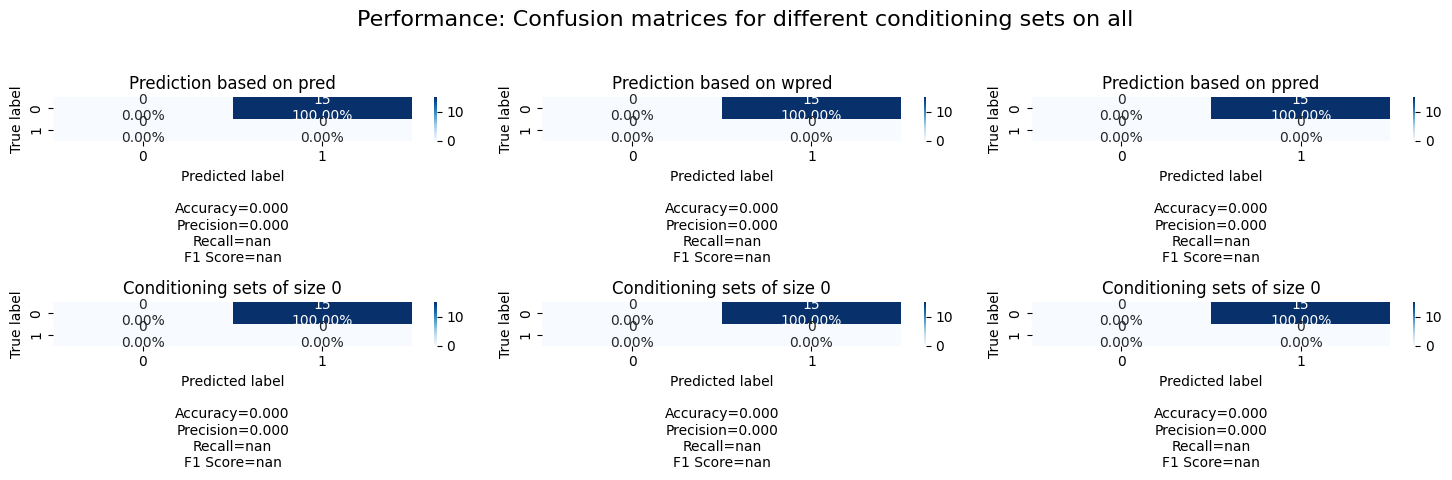

In [23]:
# Make two confusion matrices, one based on pred and one based on wpred
# and compare them
choice='all'
fig, axes = plt.subplots(len(condense_df['z_n'].unique())+1,3, figsize = (15,len(condense_df['z_n'].unique())*5))

Accuracies = []
Precisions = []
Recall = []
F1 = []

for i, pred in enumerate(['pred', 'wpred', 'ppred']):
    prediction = condense_df[pred]
    ground_truth = condense_df['answ']
    cf_matrix = confusion_matrix(ground_truth, prediction)
    out = make_confusion_matrix(cf_matrix, ax=axes[0,i], title=f'Prediction based on {pred}', reduce_matrix=True)
    
    if len(out) == 4 and pred == 'wpred':
        Accuracies.append(out[0])
        Precisions.append(out[1])
        Recall.append(out[2])
        F1.append(out[3])
    
    for j, z in enumerate(np.sort(df['z_n'].unique())):
        sub_condense_df = condense_df[condense_df['z_n'] == z]
        # reset indices of sub_condense_df
        sub_condense_df = sub_condense_df.reset_index(drop=True)

        prediction = sub_condense_df[pred]
        ground_truth = sub_condense_df['answ']
        cf_matrix = confusion_matrix(ground_truth, prediction)
        out = make_confusion_matrix(cf_matrix, ax=axes[j+1,i], title=f'Conditioning sets of size {z}', reduce_matrix=True)

        if len(out) == 4 and pred == 'wpred':
            Accuracies.append(out[0])
            Precisions.append(out[1])
            Recall.append(out[2])
            F1.append(out[3])


# add super title 
fig.suptitle(f'Performance: Confusion matrices for different conditioning sets on {choice}', fontsize=16)

# make space between subplots
plt.subplots_adjust(hspace=1.0)
# tight layout but with space for the title

plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# save in results as a pdf as performance_{choice[:5]}.pdf

plt.savefig(f'../results/performance_{choice[:5]}.pdf')

NameError: name 'Recall' is not defined

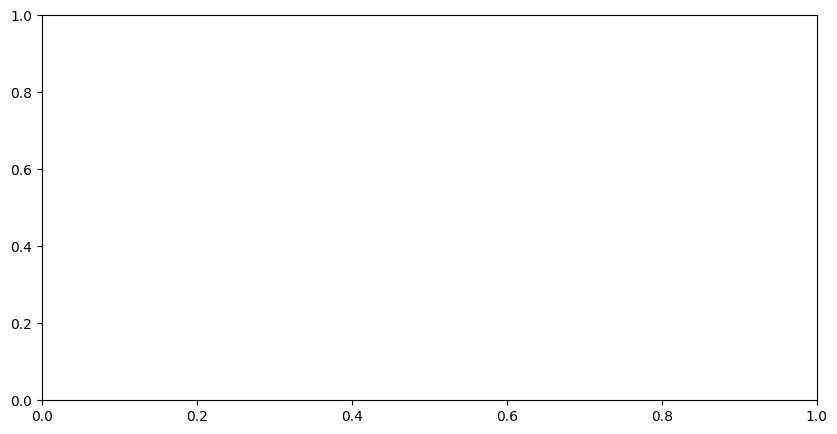

In [28]:
# Sample data (replace with your actual data)
group_names = ['All'] + [f'|Z| = {i}' for i in np.sort(df['z_n'].unique())]

# Number of groups
n_groups = len(group_names)

# Width of each bar
bar_width = 0.2

# Spacing between groups
index = np.arange(n_groups)

# Create subplots
fig, ax = plt.subplots(figsize =(10, 5))

# Go through Recall, Precisions, F1 and Accuracies and substitute the Nones with 0s
Recall = [0 if i is None else i for i in Recall]
Precisions = [0 if i is None else i for i in Precisions]
F1 = [0 if i is None else i for i in F1]
Accuracies = [0 if i is None else i for i in Accuracies]

# Plot the bars for each metric
bar1 = ax.bar(index, Accuracies, bar_width, label='Accuracy')
bar2 = ax.bar(index + bar_width, Precisions, bar_width, label='Precision')
bar3 = ax.bar(index + 2 * bar_width, Recall, bar_width, label='Recall')
bar4 = ax.bar(index + 3 * bar_width, F1, bar_width, label='F1 Score')

# Customize the plot
ax.set_xlabel('Groups')
ax.set_ylabel('Metrics')
ax.set_title(f'Classifier Performance by Group in {choice}')
ax.set_xticks(index + 1.5 * bar_width)
ax.set_xticklabels(group_names)
ax.legend()

# save pdf in results as performance_{choice[:5]}.pdf
#plt.savefig(f'../results/metrics_{choice[:5]}.pdf')

# Show the plot
plt.show()

In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Function to calculate performance metrics for a confusion matrix
def calculate_metrics(confusion_matrix):
    if confusion_matrix.shape == (1, 1):
        # For 1x1 matrix, calculate accuracy
        accuracy = accuracy_score(confusion_matrix, [1])
        return {"Accuracy": accuracy, "Precision": 0, "Recall": 0, "F1 Score": 0}
    
    elif confusion_matrix.shape == (2, 2):
        # For 2x2 matrix, calculate accuracy, precision, recall, and F1 score
        tn, fp, fn, tp = confusion_matrix.ravel()
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        
        if tp + fp == 0:
            precision = 0  # Handle division by zero
        else:
            precision = tp / (tp + fp)
            
        if tp + fn == 0:
            recall = 0  # Handle division by zero
        else:
            recall = tp / (tp + fn)

        if precision + recall == 0:
            f1_score = 0  # Handle division by zero
        else:
            f1_score = 2 * (precision * recall) / (precision + recall)
            
        return {
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1_score,
        }
    elif confusion_matrix.shape == (3, 3):
        # For 3x3 matrix, reduce to 2x2 by deleting the middle row and column
        accuracy = np.trace(confusion_matrix) / np.sum(confusion_matrix)
        
        return {"Accuracy": accuracy, "Precision": 0, "Recall": 0, "F1 Score": 0}
    else:
        raise ValueError("Invalid confusion matrix size")

# Example usage
confusion_matrix_1x1 = np.array([[20]])
confusion_matrix_2x2 = np.array([[20, 5], [10, 15]])

In [22]:
calculate_metrics(cf_matrix)

{'Accuracy': 0.61003861003861,
 'Precision': 0.5,
 'Recall': 0.45544554455445546,
 'F1 Score': 0.4766839378238342}

In [29]:
# Generate performance Table

burglary = 'burglary/2023-11-07 12:35:00.720656'  #2023-11-07 08:52:05.525438'
cancer = 'cancer_bnl/2023-11-07 13:01:43.837578'
asia = 'asia_bnl/2023-11-07 09:33:56.618510'
sachs1 = 'sachs/2023-11-07 12:08:09.402558'
sachs2 = 'sachs/2023-11-07 12:27:41.005704'

datasets = ['burglary', 'cancer', 'asia', 'sachs']
methods = ['voting', 'weighted voting', r'stat. Test ($H_0$: indep.)', r'stat. Test ($H_0$: not indep.)']

table = list()#pd.DataFrame(columns=['Dataset', 'Voting method', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

uncertain_to = 'YES'

for j, choice in enumerate([burglary, cancer,asia,sachs2]):
    path = Path.cwd().parent.joinpath('2023_GPT_PC','evaluations',choice,'predictions.csv')
    # Reading the data
    df = pd.read_csv(path, index_col=0)
    df['z'] = df['z'].fillna('[]')
    df['z_n'] = np.array([len(literal_eval(z)) for z in df['z']])

    # 

#    for i in range(len(df)):
#        df.loc[i,'ppred_YES'], df.loc[i,'p'] = test_prop(df.loc[i,'n_no'], df.loc[i,'n_yes'], df.loc[i,'n'], null='YES')
#        df.loc[i,'ppred_NO'], df.loc[i,'p'] = test_prop(df.loc[i,'n_no'], df.loc[i,'n_yes'], df.loc[i,'n'], null='NO')

    # run this to concatenate consecutive rows having XY and YX reponse
    condense_df = pd.DataFrame(columns=df.columns)

    for i in range(0, len(df), 2):
        new_row = condense_lines(df.iloc[i], df.iloc[i+1])
        condense_df.loc[len(condense_df)] = new_row

    if datasets[j] == 'sachs':
        path2 = Path.cwd().parent.joinpath('2023_GPT_PC','evaluations','sachs/2023-11-07 12:08:09.402558','predictions.csv')
        df2 = pd.read_csv(path2, index_col=0)
        df2['z'] = df2['z'].fillna('[]')
        df2['z_n'] = np.array([len(literal_eval(z)) for z in df2['z']])
#        for i in range(len(df2)):
#            df2.loc[i,'ppred_YES'], df2.loc[i,'p'] = test_prop(df2.loc[i,'n_no'], df2.loc[i,'n_yes'], df2.loc[i,'n'], null='YES')
 #           df2.loc[i,'ppred_NO'], df2.loc[i,'p'] = test_prop(df2.loc[i,'n_no'], df2.loc[i,'n_yes'], df2.loc[i,'n'], null='NO')

        condense_df = pd.concat([condense_df, df2])
        condense_df = condense_df.reset_index(drop=True)

    for i in range(len(condense_df)):
        condense_df.loc[i,'ppred_YES'], condense_df.loc[i,'p'] = test_prop(condense_df.loc[i,'n_no'], condense_df.loc[i,'n_yes'], condense_df.loc[i,'n'], null='YES')
        condense_df.loc[i,'ppred_NO'], condense_df.loc[i,'p'] = test_prop(condense_df.loc[i,'n_no'], condense_df.loc[i,'n_yes'], condense_df.loc[i,'n'], null='NO')
    
    # substitute every value 'uncertain" in column 'pred' with 'YES'
    condense_df['pred'] = condense_df['pred'].replace('Uncertain', uncertain_to)    
    
    # compute the ratio between number of YES and NO predictions in condense_df['answer']
    
    baseline = dict()
    baseline[condense_df['answ'].unique()[0]] = condense_df['answ'].value_counts(sort=False)[0]/len(condense_df)
    baseline[condense_df['answ'].unique()[1]] = condense_df['answ'].value_counts(sort=False)[1]/len(condense_df)
    
    TP = 1*baseline['YES']
    TN = 0*baseline['NO']
    FP = 0*baseline['YES']
    FN = 1*baseline['NO']
    
    # compute Accuracy, Precision, Recall, F1 score from TP TN FP and FN
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    f1_score = 2*precision*recall/(precision+recall)
    
    # Add them to the baseline dict
    baseline['Accuracy'] = accuracy
    baseline['Precision'] = precision
    baseline['Recall'] = recall
    baseline['F1 Score'] = f1_score
    
    print(baseline)
    
    for i, pred in enumerate(['pred', 'wpred', 'ppred_YES', 'ppred_NO']):
        prediction = condense_df[pred]
        ground_truth = condense_df['answ']
        cf_matrix = confusion_matrix(ground_truth, prediction, labels=['NO','YES'])
        out = calculate_metrics(cf_matrix)
    
        out['Dataset'] = datasets[j]
        out['Prediction method'] = methods[i]
    
        table.append(out)

table = pd.DataFrame(table)

# Run this in case of Sachs1 (data where there are not responses of XY and YX)
# condense_df = df


/tmp/ipykernel_14957/3159886251.py:49: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'YES' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  condense_df.loc[i,'ppred_YES'], condense_df.loc[i,'p'] = test_prop(condense_df.loc[i,'n_no'], condense_df.loc[i,'n_yes'], condense_df.loc[i,'n'], null='YES')
/tmp/ipykernel_14957/3159886251.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'YES' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  condense_df.loc[i,'ppred_NO'], condense_df.loc[i,'p'] = test_prop(condense_df.loc[i,'n_no'], condense_df.loc[i,'n_yes'], condense_df.loc[i,'n'], null='NO')
/tmp/ipykernel_14957/3159886251.py:58: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as label

{'YES': 0.275, 'NO': 0.725, 'Accuracy': 0.275, 'Precision': 1.0, 'Recall': 0.275, 'F1 Score': 0.4313725490196079}


/tmp/ipykernel_14957/3159886251.py:58: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  baseline[condense_df['answ'].unique()[0]] = condense_df['answ'].value_counts(sort=False)[0]/len(condense_df)
/tmp/ipykernel_14957/3159886251.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  baseline[condense_df['answ'].unique()[1]] = condense_df['answ'].value_counts(sort=False)[1]/len(condense_df)


{'NO': 0.875, 'YES': 0.125, 'Accuracy': 0.125, 'Precision': 1.0, 'Recall': 0.125, 'F1 Score': 0.2222222222222222}


/tmp/ipykernel_14957/3159886251.py:49: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'NO' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  condense_df.loc[i,'ppred_YES'], condense_df.loc[i,'p'] = test_prop(condense_df.loc[i,'n_no'], condense_df.loc[i,'n_yes'], condense_df.loc[i,'n'], null='YES')
/tmp/ipykernel_14957/3159886251.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'NO' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  condense_df.loc[i,'ppred_NO'], condense_df.loc[i,'p'] = test_prop(condense_df.loc[i,'n_no'], condense_df.loc[i,'n_yes'], condense_df.loc[i,'n'], null='NO')
/tmp/ipykernel_14957/3159886251.py:58: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels 

{'NO': 0.9132653061224489, 'YES': 0.08673469387755102, 'Accuracy': 0.08673469387755102, 'Precision': 1.0, 'Recall': 0.08673469387755102, 'F1 Score': 0.1596244131455399}
{'NO': 0.61003861003861, 'YES': 0.38996138996138996, 'Accuracy': 0.38996138996138996, 'Precision': 1.0, 'Recall': 0.38996138996138996, 'F1 Score': 0.5611111111111111}


/tmp/ipykernel_14957/3159886251.py:58: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  baseline[condense_df['answ'].unique()[0]] = condense_df['answ'].value_counts(sort=False)[0]/len(condense_df)
/tmp/ipykernel_14957/3159886251.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  baseline[condense_df['answ'].unique()[1]] = condense_df['answ'].value_counts(sort=False)[1]/len(condense_df)


In [30]:
# Show from table only 
# give me markdown version of the table
# but only two decimals
    
print(table[['Dataset', 'Prediction method','Accuracy', 'Precision', 'Recall', 'F1 Score']].to_markdown(floatfmt=".2f"))

|    | Dataset   | Prediction method              |   Accuracy |   Precision |   Recall |   F1 Score |
|---:|:----------|:-------------------------------|-----------:|------------:|---------:|-----------:|
|  0 | burglary  | voting                         |       0.54 |        0.26 |     0.36 |       0.30 |
|  1 | burglary  | weighted voting                |       0.55 |        0.29 |     0.45 |       0.36 |
|  2 | burglary  | stat. Test ($H_0$: indep.)     |       0.55 |        0.27 |     0.36 |       0.31 |
|  3 | burglary  | stat. Test ($H_0$: not indep.) |       0.55 |        0.27 |     0.36 |       0.31 |
|  4 | cancer    | voting                         |       0.88 |        0.00 |     0.00 |       0.00 |
|  5 | cancer    | weighted voting                |       0.88 |        0.00 |     0.00 |       0.00 |
|  6 | cancer    | stat. Test ($H_0$: indep.)     |       0.88 |        0.00 |     0.00 |       0.00 |
|  7 | cancer    | stat. Test ($H_0$: not indep.) |       0.88 |        0

In [27]:
%load_ext autoreload
%autoreload 2

import pybnesian as bn
from causallearn.search.ConstraintBased.PC import pc

import networkx as nx
import matplotlib.pyplot as plt

import pandas as pd
from pathlib import Path
import numpy as np

import ast
import yaml
import sys
from dotenv import load_dotenv
import os

import openai
import git
from datetime import datetime
import asyncio 
import logging 

/home/kaicohrs/Repositories/causal_GPT/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


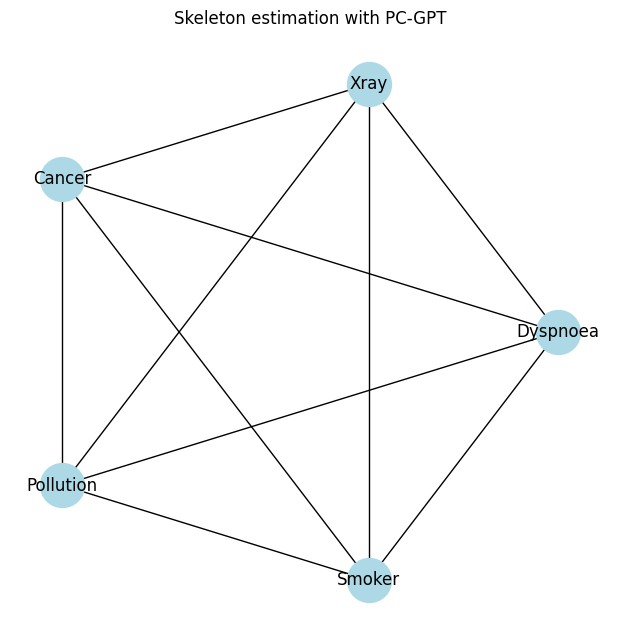

<Figure size 640x480 with 0 Axes>

In [ ]:
basepath = Path.cwd().parent
experiment_path = basepath.joinpath('results', 'food_insecurity')
sys.path.append('../')
from gptci import *

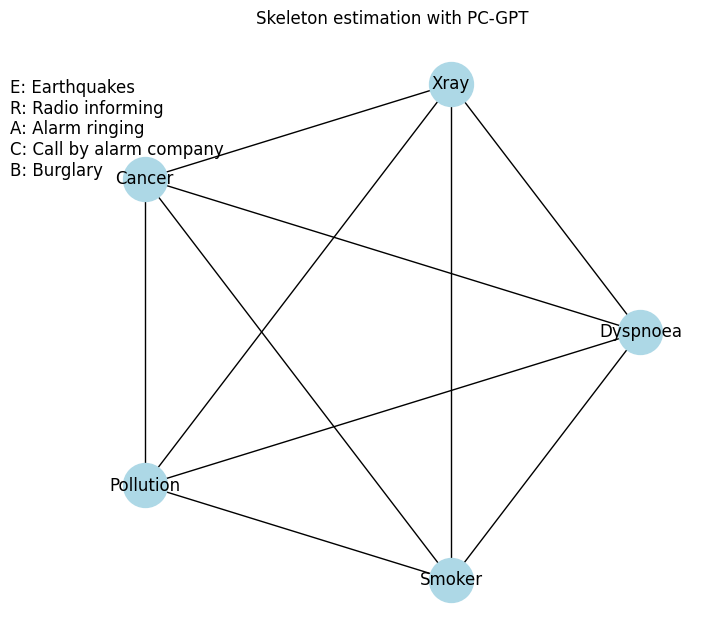

<Figure size 640x480 with 0 Axes>

In [25]:
basepath = Path.cwd().parent
experiment_path = basepath.joinpath('results', 'food_insecurity_2', 'predictions.csv')
predictions = pd.read_csv(experiment_path)

In [26]:
# if entry in predictions['z'] is not a list store in list
predictions['z'] = predictions['z'].apply(lambda x: [x] if (isinstance(x, str) and x!="[]") else x)
#predictions['z'] = predictions['z'].apply(lambda x: ast.literal_eval(x) if ~isinstance(x, list) else x)

In [27]:
predictions['z']

['livestock_prices']

In [3]:
data = pd.read_csv(experiment_path.joinpath('horn_africa_food_data.csv')).astype(float)


NameError: name 'experiment_path' is not defined

In [6]:
#LinearCorrelation, MutualInformation, KMutualInformation, RCoT, ChiSquare, DynamicLinearCorrelation, DynamicMutualInformation, DynamicKMutualInformation, DynamicRCoT, DynamicChiSquare
test = bn.MutualInformation(data)
pc = bn.PC()

/home/kaicohrs/Repositories/causal_GPT/env/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


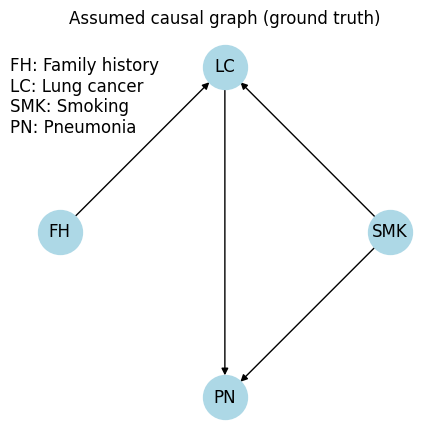

In [68]:
test.pvalue('enso', 'spi', [])

In [36]:
graph = pc.estimate(test)

FileNotFoundError: [Errno 2] No such file or directory: 'raw.yml'

In [37]:
print(f"arcs: {graph.arcs()}")
print(f"edges : {graph.edges()}")

arcs: [('population', 'sorghum_production'), ('livestock_prices', 'population'), ('enso', 'gam_norm'), ('fatalities', 'enso'), ('food_prices', 'enso'), ('livestock_prices', 'enso'), ('idp_drought', 'livestock_prices'), ('water_prices', 'livestock_prices'), ('enso', 'livestock_prices'), ('spi', 'livestock_prices'), ('spi', 'food_prices'), ('enso', 'food_prices'), ('gam_norm', 'population'), ('gam_norm', 'food_prices'), ('food_prices', 'water_prices'), ('livestock_prices', 'water_prices')]
edges : [('spi', 'idp_drought'), ('spi', 'fatalities')]


In [7]:
def render_output(graph, variables):
    # Create a directed graph
    G = nx.DiGraph()

    for node in variables:
        G.add_node(node)

    # Add nodes and edges to the graph
    G.add_edges_from(graph.arcs())
    G.add_edges_from(graph.edges())
    G.add_edges_from([(b,a) for (a,b) in graph.edges()])
    
    # Draw the graph
    pos = nx.circular_layout(G)  # You can choose different layout algorithms
    nx.draw(G, pos, with_labels=True, font_weight='bold', node_size=700, node_color='skyblue', font_size=8, arrowsize=15)

    # Display the graph
    plt.show()

In [8]:
render_output(graph)

NameError: name 'graph' is not defined

In [9]:
def test_prop(n_no, n_yes, n, null = "YES", alpha = 0.05):
    p_no = n_no / n # prop of no
    p_yes = n_yes / n # prop of yes
    p = (n_no + n_yes) / (2*n) # pooled prop 
    se = np.sqrt( p * (1 - p) * 2 / n) # standard error 
    if null == "YES":  
        answ = "YES"
        pval = norm.sf((p_no - p_yes) / se) # p_no - p_yes >> 0 is extreme for null == "YES" 
        if pval <= alpha:
            answ = "NO"
    if null == "NO":
        answ = "NO"
        pval = norm.sf((p_yes - p_no) / se) # p_yes - p_no >> 0 is extreme for null == "NO" 
        if pval <= alpha:
            answ = "YES"
    return answ, pval

In [10]:
# Design a new test
from pybnesian import IndependenceTest

class HybridGPTIndependenceTest(IndependenceTest):
    def __init__(self, data_info, pre_stored_file, gpt_variables = None, data_driven_test=None, method = "vot", null = "YES", test_list=None):
        # IMPORTANT: Always call the parent class to initialize the C++ object.
        IndependenceTest.__init__(self)
        self.data_info = data_info
        self.null = null
        self.data_driven_test = data_driven_test
        self.gpt_variables = gpt_variables
        self.test_list = []
        self.method=method
        
        # extract variable names from data dictionary
        self.variables = [var['name'] for var in self.data_info['variables']]
        self.pre_stored_file = pre_stored_file
        self.current_level = -1 # value for level-wise increase with gpt queries
            
    def num_variables(self):
        return len(self.variables)

    def variable_names(self):
        return self.variables

    def has_variables(self, vars):
        return set(vars).issubset(set(self.variables))

    def name(self, index):
        return self.variables[index]

    def pvalue(self, x, y, z):
        # Make sure that z is a list
        if isinstance(z, str):
            z = [z]
        if z is None:
            z = []
        
        # check if one of the strings in x+y+z is in gpt_variables
        if len(set(z+[x]+[y]) & set(self.gpt_variables)) > 0:        
            
            rowXY = self.pre_stored_file.loc[(self.pre_stored_file['x'] == x) & (self.pre_stored_file['y'] == y) & (np.array([set(Z) for Z in self.pre_stored_file['z']]) ==set(z))]
            rowYX = self.pre_stored_file.loc[(self.pre_stored_file['y'] == x) & (self.pre_stored_file['x'] == y) & (np.array([set(Z) for Z in self.pre_stored_file['z']]) ==set(z))]
            # union of both dataframes
            row = pd.concat([rowXY, rowYX])

            if len(row) >= 1:
                if len(row) > 1:
                    print(f"Warning: more than one row found in pre-stored file for statement {x} indep {y} given {z}. Average output reponse.")
        
                n_no = row['n_no'].sum()
                n_yes = row['n_yes'].sum()
                nn = row['n'].sum()
                
                if self.method == "stat":
                    answ, pval = test_prop(n_no, n_yes, nn, null = self.null, alpha = 0.05)
                    if answ == "NO":
                        return 0
                    if answ == "YES":
                        return 1

                if self.method == "vot":
                    if n_no > n_yes:
                        # NO wins voting, not independent, significant evidence against conditional independence
                        return 0
                    if n_yes >  n_no:
                        # YES wins voting, independent, or rather no significant evidence against conditional independence
                        return 1
                    if n_yes == n_no:
                        if self.null == "YES":
                            return 1
                        if self.null == "NO":
                            return 0

                if self.method == "wvot":
                    return 0
                    ##TODO
                        
            if row.empty:
                if self.current_level != -1 and len(z) > self.current_level:
                    return 0
                else:
                    self.test_list.append({'x': x, 'y': y, "z": z})     
                    self.current_level = len(z)
                    return 1
        else:
            return self.data_driven_test.pvalue(x,y,z)
            


In [11]:
with open(experiment_path.joinpath('horn_africa_food_info.yaml')) as file:
    data_info = yaml.safe_load(file)

for v in data_info['variables']:
    print("{name}: {description}".format(**v))
variables = [v['name'] for v in data_info['variables']]

n = 1
enso_parent = list(((v, 'enso') for v in variables if v != 'enso'))
spi_parent = list(((v, 'spi') for v in variables if v not in ['enso', 'spi']))
black_list = enso_parent + spi_parent

with open(experiment_path.joinpath('horn_africa_food_black_list.yaml'), 'w') as yaml_file:
    yaml.dump(black_list, yaml_file, default_flow_style=False)

gpt_variables = ['enso']

# read relevant files:
load_dotenv()
openai.api_key = os.getenv("OPENAI_API_KEY")
openai.util.logger.setLevel(logging.WARNING)


with open(experiment_path.joinpath('horn_africa_food_black_list.yaml')) as file:
    black_list = yaml.load(file, Loader=yaml.FullLoader)

with open(experiment_path.joinpath('horn_africa_food_listed.yaml')) as file:
    listed = yaml.load(file, Loader=yaml.FullLoader)

data = pd.read_csv(experiment_path.joinpath("horn_africa_food_data.csv")).astype(float)


enso: El Nino Southern Oscillation - To account for climate variability we collect data on ENSO from the World Meteorological Organization (WMO). ENSO phases are then categorized according to the Oceanic El Niño Index (ONI), which is based on a 3-month running mean of Sea Surface Temperature (SST) anomaly in the Niño 3.4 region, considered to be the most sensitive region to fluctuations, duration, and magnitude of ENSO events.
spi: Precipitation - Standardized Precipitation Index to characterize dry spells
fatalities: Violent Conflict - Proxy based on recorded fatalities
food_prices: Market prices of staple food
livestock_prices: Market prices of livestock
water_prices: Market prices of water
sorghum_production: Yield - Shorghum yield production
idp_drought: Drought Displacement - Drought-induced internal displacement.
population: Population - Population of Somalian districts.
cred_plus_rem_norm: Received Cash - Number of individuals that received cash.
gam_norm: Global Acute Malnutrit

✔  [██████████████████��█████████████████████] 100% :00s] Finished PC!less


/home/kaicohrs/Repositories/causal_GPT/env/lib/python3.10/site-packages/pyarrow/pandas_compat.py:373: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if _pandas_api.is_sparse(col):


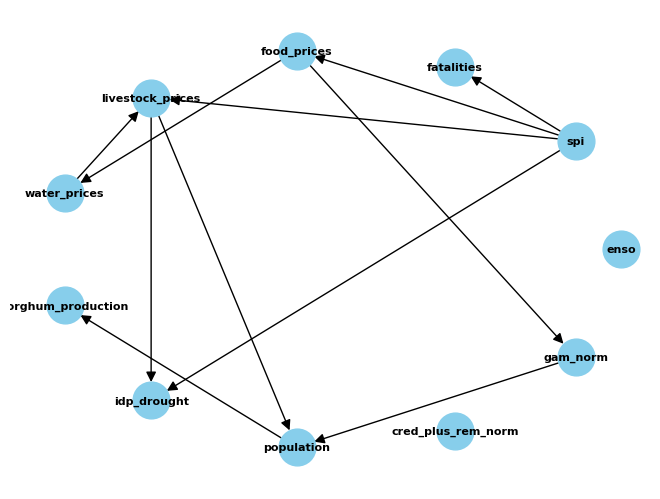

---------------------------
To be tested: [{'x': 'enso', 'y': 'spi', 'z': []}, {'x': 'enso', 'y': 'fatalities', 'z': []}, {'x': 'enso', 'y': 'food_prices', 'z': []}, {'x': 'enso', 'y': 'livestock_prices', 'z': []}, {'x': 'enso', 'y': 'water_prices', 'z': []}, {'x': 'enso', 'y': 'sorghum_production', 'z': []}, {'x': 'enso', 'y': 'idp_drought', 'z': []}, {'x': 'enso', 'y': 'population', 'z': []}, {'x': 'enso', 'y': 'cred_plus_rem_norm', 'z': []}, {'x': 'enso', 'y': 'gam_norm', 'z': []}]
Current level: 0
---------------------------
listed ci statements in the data file


100%|██████████| 20/20 [00:00<00:00, 4511.22it/s]

total task executed: 20



/tmp/ipykernel_62061/1842157746.py:62: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pre_stored_file = pd.concat([pre_stored_file, cisdf], ignore_index=True)


In [12]:
for i in range(1):
    pre_stored_file = pd.read_csv(experiment_path.joinpath('predictions.csv'), index_col=0)
    pre_stored_file['z'].fillna('[]', inplace=True)
    pre_stored_file['z'] = pre_stored_file['z'].apply(lambda x: ast.literal_eval(x))

    with open(experiment_path.joinpath('horn_africa_food_listed.yaml')) as file:
        listed = yaml.load(file, Loader=yaml.FullLoader)
    
    # while listed is not empty
    pc = bn.PC()
    data_driven_test = bn.MutualInformation(data)

    gptcit = HybridGPTIndependenceTest(data_info, pre_stored_file = pre_stored_file, gpt_variables = gpt_variables, data_driven_test=data_driven_test, method='vot')
    graph = pc.estimate(gptcit, verbose=True, allow_bidirected = False, arc_blacklist=black_list)
    render_output(graph, variables)
    
    # Example list
    test_list = gptcit.test_list
    print("---------------------------")
    print(f"To be tested: {test_list}")
    print(f"Current level: {gptcit.current_level}")

    # Write the list to the YAML file
    with open(experiment_path.joinpath('horn_africa_food_listed.yaml'), 'w') as yaml_file:
        yaml.dump(test_list, yaml_file, default_flow_style=False)
        
    with open(experiment_path.joinpath('horn_africa_food_listed.yaml')) as file:
        listed = yaml.load(file, Loader=yaml.FullLoader)
        

    print("---------------------------")
    print("listed ci statements in the data file")
    listed_cis = test_list
    cis = []
    for ci in listed_cis:
        ci.update({"type":"listed"})
        cis.append(ci)
        cis.append({'x':ci['y'], 'y':ci['x'], 'z':ci['z'], 'type':'listed'})
    
    ### tmstamp and git hash 
    tmstp = str(datetime.now())
    repo = git.Repo(search_parent_directories=True)
    sha = repo.head.object.hexsha

    # get results 
    results = await gpt_cis(cis, data_info,
            model="gpt-3.5-turbo",
            n=n,
            temperature=0.6, tdelay = 0,
            dryrun = True, verbose = False)
        
    ## append results to cis 
    for i in range(len(cis)):
        result = results[i][0] #generate_random_dict(n) # = 
        
        cis[i].update(result)
        cis[i].update({"sha" : sha, "tmstmp" : tmstp, 
                        "model" : "gpt-3.5-turbo", "temperature" : 0.6}) 

    ######### prepare final results
    cisdf = pd.DataFrame(cis)
    pre_stored_file = pd.concat([pre_stored_file, cisdf], ignore_index=True)
    pre_stored_file.to_csv(experiment_path.joinpath('predictions.csv'))



In [117]:
listed_cis

[]

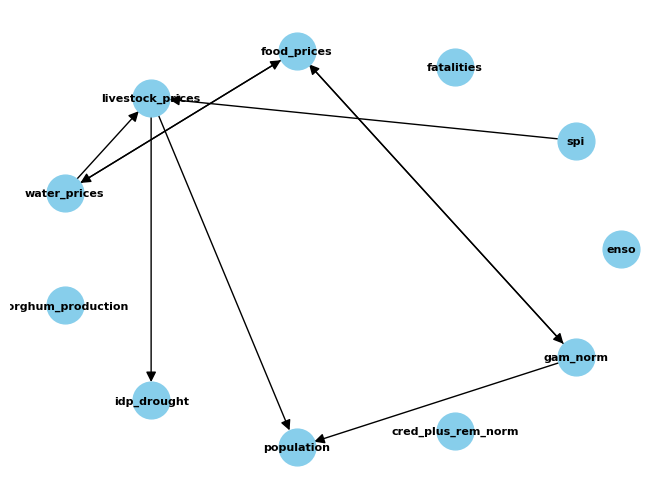

In [91]:
render_output(graph, variables)

In [48]:
vars

<function vars>

In [95]:
import random
import numpy as np

def generate_random_dict(n):
    # Generate random values
    pred = 'NO' #random.choice(['YES', 'NO'])
    wpred = 'NO' #random.choice(['YES', 'NO'])
    n_no = 1 #random.randint(0, n)
    n_yes = 0 #n - n_no
    n_total = n
    no_conf = random.uniform(0, 1)
    yes_conf = random.uniform(0, 1)
    sum_rep_no_conf = random.uniform(0, 1)
    sum_rep_yes_conf = random.uniform(0, 1)
    
    # Calculate averages, std, median, and quartiles
    avg_rep_conf = (sum_rep_no_conf + sum_rep_yes_conf) / 2
    avg_rep_no_conf = sum_rep_no_conf / max(n_no, 1)
    avg_rep_yes_conf = sum_rep_yes_conf / max(n_yes, 1)
    
    std_rep_conf = np.std([sum_rep_no_conf, sum_rep_yes_conf])
    std_rep_no_conf = np.std([sum_rep_no_conf])
    std_rep_yes_conf = np.std([sum_rep_yes_conf])
    
    med_rep_conf = np.median([sum_rep_no_conf, sum_rep_yes_conf])
    med_rep_no_conf = np.median([sum_rep_no_conf])
    med_rep_yes_conf = np.median([sum_rep_yes_conf])
    
    q25_rep_conf = np.percentile([sum_rep_no_conf, sum_rep_yes_conf], 25)
    q25_rep_no_conf = np.percentile([sum_rep_no_conf], 25)
    q25_rep_yes_conf = np.percentile([sum_rep_yes_conf], 25)
    
    q75_rep_conf = np.percentile([sum_rep_no_conf, sum_rep_yes_conf], 75)
    q75_rep_no_conf = np.percentile([sum_rep_no_conf], 75)
    q75_rep_yes_conf = np.percentile([sum_rep_yes_conf], 75)
    
    # Create the dictionary
    random_dict = {
        'pred': pred,
        'wpred': wpred,
        'n_no': n_no,
        'n_yes': n_yes,
        'n': n_total,
        'no_conf': no_conf,
        'yes_conf': yes_conf,
        'sum_rep_no_conf': sum_rep_no_conf,
        'sum_rep_yes_conf': sum_rep_yes_conf,
        'avg_rep_conf': avg_rep_conf,
        'avg_rep_no_conf': avg_rep_no_conf,
        'avg_rep_yes_conf': avg_rep_yes_conf,
        'std_rep_conf': std_rep_conf,
        'std_rep_no_conf': std_rep_no_conf,
        'std_rep_yes_conf': std_rep_yes_conf,
        'med_rep_conf': med_rep_conf,
        'med_rep_no_conf': med_rep_no_conf,
        'med_rep_yes_conf': med_rep_yes_conf,
        'q25_rep_conf': q25_rep_conf,
        'q25_rep_no_conf': q25_rep_no_conf,
        'q25_rep_yes_conf': q25_rep_yes_conf,
        'q75_rep_conf': q75_rep_conf,
        'q75_rep_no_conf': q75_rep_no_conf,
        'q75_rep_yes_conf': q75_rep_yes_conf
    }
    
    return random_dict

In [8]:
load_dotenv()
openai.api_key = os.getenv("OPENAI_API_KEY")

openai.util.logger.setLevel(logging.WARNING)

print("---------------------------")
print("listed ci statements in the data file")
listed_cis = test_list
cis = []
for ci in listed_cis:
    ci.update({"type":"listed"})
cis = cis + listed_cis
    
### tmstamp and git hash 
tmstp = str(datetime.now())
repo = git.Repo(search_parent_directories=True)
sha = repo.head.object.hexsha

## get results 
results = await gpt_cis(cis, data_info,
        model="gpt-3.5-turbo",
        n=1,
        temperature=0.6, tdelay = 0,
        dryrun = False, verbose = False)
    
## append results to cis 
for i in range(len(cis)):
    
    cis[i].update(results[i][0])
    cis[i].update({"sha" : sha, "tmstmp" : tmstp, 
                    "model" : "gpt-3.5-turbo", "temperature" : 0.6}) 

######### prepare final results
cisdf = pd.DataFrame(cis)
predictions = pre_stored_file.append(cisdf, ignore_index=True)


---------------------------
listed ci statements in the data file


100%|██████████| 10/10 [00:09<00:00,  1.05it/s]

total task executed: 10


AttributeError: 'DataFrame' object has no attribute 'append'

In [15]:
pre_stored_file

,Unnamed: 0,x,y,z,answ,pred,wpred,n_no,n_yes,n,...,med_rep_conf,med_rep_no_conf,med_rep_yes_conf,q25_rep_conf,q25_rep_no_conf,q25_rep_yes_conf,q75_rep_conf,q75_rep_no_conf,q75_rep_yes_conf,data


In [16]:
predictions = pd.concat([pre_stored_file, cisdf], ignore_index=True)

/tmp/ipykernel_41962/4240338880.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  predictions = pd.concat([pre_stored_file, cisdf], ignore_index=True)


In [123]:
with open(experiment_path.joinpath('horn_africa_food_listed.yaml')) as file:
    listed = yaml.load(file, Loader=yaml.FullLoader)

In [118]:
gptcit.test_list

[('enso', 'spi', []),
 ('enso', 'fatalities', []),
 ('enso', 'food_prices', []),
 ('enso', 'livestock_prices', []),
 ('enso', 'water_prices', []),
 ('enso', 'sorghum_production', []),
 ('enso', 'idp_drought', []),
 ('enso', 'population', []),
 ('enso', 'cred_plus_rem_norm', []),
 ('enso', 'gam_norm', [])]

In [86]:
data_info
data_driven_test
gpt_variables = None
method = "vot"
null = "YES"
pre_stored_file=None